# 2023-09-08 13 - Estimating more precise constraint levels.ipynb
In NB 5 and 9, we decided on $\epsilon$ based on the results of ERM runs on Autoformer, however, the ERM MSEs are quite different in general. 

Here we explore the EMR losses on a subset of the previous experiments to get an epsilon per `(dataset,model,pred_len)`

## Fetching runs

In [30]:
import wandb
from math import isnan 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wandb
from tqdm import tqdm
# from cycler import cycler
import matplotlib as mpl
from IPython.display import Markdown, display
    
api = wandb.Api()
project = "Autoformer"
workspace = "alelab"

experiment_tags = [
    "e1_weather_10e_statinformed",
    "e2_electricity_10e_statinformed",
    "e3_weather_10e_statinformed_seeds23",
    "e4_electricity_10e_statinformed_seeds23"
    ]

# get all runs that both: 1.  match any experiment tag and 2. are finished
runs = api.runs(f"{workspace}/{project}",
                {"$and": [
                    {"tags": {"$in": experiment_tags}},
                    # Get only ERM runs: {"config.dual_lr": 0},
                    {"config.dual_lr": 0},
                    {"state": "finished"}
                ]})

def tag_experiment(run):
    for tag in experiment_tags:
        if tag in run.tags:
            return tag
    return ''

def runs_into_df(runs):
    all_runs = []
    run_counter = 0
    for run in tqdm(runs):
        run_counter += 1
        for split in ["train", "test","val"]:
            for metric in ["mse",]:
                pred_len = run.config["pred_len"]
                metrics = np.zeros(pred_len)
                for i in range(pred_len):
                    run_dict = {**run.config}
                    #run_dict["constraint_level"] = constraint_level
                    run_dict[f"{metric}"] = run.summary[f"{metric}/{split}/{i}"]
                    #run_dict[f"{metric}"] = run.summary.get(f"{metric}/{split}/{i}",run.summary.get(f"mse/{split}/{i}",np.nan)) #god forgive me for this line
                    run_dict["step"]=i
                    run_dict["epoch"]=run.summary["epoch"]
                    run_dict["infeasible_rate"]=run.summary[f"infeasible_rate/{split}"]
                    run_dict["infeasibles"]=run.summary[f"infeasibles/{split}"]
                    run_dict[f"multiplier"] = run.summary[f"multiplier/{i}"] if split == "train" else np.nan
                    run_dict["split"] = split
                    run_dict["run_id"] = run.id
                    # Get either Constrained/ or ERM/ from the run name, then append model name.
                    #print("run.name", run.name)
                    #debug if ERM run
                    run_dict["Algorithm"] = f"{run.name.split('/')[0]} {run.config['model']}"
                    run_dict["sweep_id"] = run.sweep.id if run.sweep else ''
                    #print("Algorithm", run_dict["Algorithm"])

                    # Get the experiment tag
                    run_dict["experiment_tag"] = tag_experiment(run)

                    # To better plot constrained vs ERM
                    #TODO this is a hack while I consolidate the tags. 
                    run_dict["type"] = "ERM" if run.config['dual_lr'] == 0 else "Constrained"

                    all_runs.append(run_dict)
    print(f"Fetched {run_counter} runs")
    df = pd.DataFrame(all_runs)
    print(f"Total records: {(df.shape)}")
    print(f"Total runs: {df.run_id.nunique()}")
    return df
df = runs_into_df(runs)

In [4]:
df[['run_id',"sweep_id",'Algorithm',"type",'model','data_path','constraint_level','pred_len']].drop_duplicates().sort_values(['model',"pred_len","constraint_level"])

,run_id,sweep_id,Algorithm,type,model,data_path,constraint_level,pred_len
13968,3mwa9f8k,0hgr8saw,StatInformed-ERM-10e Autoformer,ERM,Autoformer,weather.csv,-1,96
15840,gmhaqlxe,h28xy1us,StatInformed-ERM-10e Autoformer,ERM,Autoformer,electricity.csv,-1,96
23904,hx3z6ie8,2yuqa7f7,StatInformed-ERM-10e Autoformer,ERM,Autoformer,weather.csv,-1,96
31968,euzmqha2,56r4k8t7,StatInformed-ERM-10e Autoformer,ERM,Autoformer,electricity.csv,-1,96
40032,dky72mnn,plrzt70h,StatInformed-ERM-10e Autoformer,ERM,Autoformer,electricity.csv,-1,96
48096,ne4liw91,fi1lnhc1,StatInformed-ERM-10e Autoformer,ERM,Autoformer,weather.csv,-1,96
10944,9qwoyt70,0hgr8saw,StatInformed-ERM-10e Autoformer,ERM,Autoformer,weather.csv,-1,192
15264,w77g985i,h28xy1us,StatInformed-ERM-10e Autoformer,ERM,Autoformer,electricity.csv,-1,192
23328,aon3bqa6,2yuqa7f7,StatInformed-ERM-10e Autoformer,ERM,Autoformer,weather.csv,-1,192
31392,pablr64n,56r4k8t7,StatInformed-ERM-10e Autoformer,ERM,Autoformer,electricity.csv,-1,192


# Get IQR for all models, and pred lengths, datasets
Note that the IQRs are vastly different for autoformer and reformer.

In [15]:
stats=df.query("split=='val'").groupby(['data_path','model','pred_len'])['mse'].describe().reset_index()
stats[['data_path','model','pred_len','25%','50%','75%','mean','std']].sort_values(['data_path','pred_len','model'])

,data_path,model,pred_len,25%,50%,75%,mean,std
0,electricity.csv,Autoformer,96,0.146462,0.153939,0.165615,0.155993,0.012425
4,electricity.csv,Reformer,96,0.198294,0.201321,0.205898,0.202487,0.005337
1,electricity.csv,Autoformer,192,0.179408,0.192899,0.205408,0.193265,0.018967
5,electricity.csv,Reformer,192,0.219726,0.235345,0.246785,0.234747,0.015140
2,electricity.csv,Autoformer,336,0.195968,0.219184,0.238180,0.218942,0.028214
6,electricity.csv,Reformer,336,0.225283,0.235210,0.253416,0.239215,0.015526
3,electricity.csv,Autoformer,720,0.215230,0.228747,0.244668,0.235728,0.038535
7,electricity.csv,Reformer,720,0.249865,0.252769,0.255325,0.252606,0.005078
8,weather.csv,Autoformer,96,0.495470,0.550217,0.555633,0.518399,0.059128
12,weather.csv,Reformer,96,0.449399,0.526012,0.563017,0.489602,0.096644


## Will using the proper constraint level affect the results?
Check with a single run of electricity 192:

In [61]:
# Get runs for run_id 0szccmi4
# runs = api.runs(f"{workspace}/{project}",
#                 {"$and": [
#                     {"tags": {"$in": experiment_tags}},
#                     # Get only ERM runs: {"config.dual_lr": 0},
#                     {"config.dual_lr": 0},
#                     {"state": "finished"}
#                 ]})
reformer_electricity_192=runs_into_df(api.runs(f"{workspace}/{project}",filters={"name":"0szccmi4"})) # relaxed constraint
reformer_electricity_192=runs_into_df(api.runs(f"{workspace}/{project}",filters={"name":"zmujc4le"})) # constraint to 0
erm_electricity_192 = runs_into_df(api.runs(f"{workspace}/{project}",filters={"name":"4dsfg2z8"}))
old_reformer = runs_into_df(api.runs(f"{workspace}/{project}",filters={"name":"ywgdifbd"}))
old_reformer_erm_ref = erm_electricity_192.copy()
# Add a column to differentiate.
reformer_electricity_192['reference'] = "new"
erm_electricity_192['reference'] = "new"
old_reformer['reference'] = "old"
old_reformer_erm_ref['reference'] = "old"
# concat all
to_plot = pd.concat([reformer_electricity_192,erm_electricity_192,old_reformer,old_reformer_erm_ref],axis=0)


100%|██████████| 1/1 [00:00<00:00, 73.47it/s]


Fetched 1 runs
Total records: (576, 64)
Total runs: 1


100%|██████████| 1/1 [00:00<00:00, 74.52it/s]


Fetched 1 runs
Total records: (576, 64)
Total runs: 1


100%|██████████| 1/1 [00:00<00:00, 88.08it/s]


Fetched 1 runs
Total records: (576, 63)
Total runs: 1


100%|██████████| 1/1 [00:00<00:00, 90.00it/s]

Fetched 1 runs
Total records: (576, 63)
Total runs: 1


run_id     model        data_path constraint_level       mse  \
split                                                                test   
reference                                                             new   
0          4dsfg2z8  Reformer  electricity.csv           -1.000  0.236125   
1          ywgdifbd  Reformer  electricity.csv            0.184       NaN   
2          zmujc4le  Reformer  electricity.csv            0.184  0.241924   

                                                             
split                   train                 val            
reference       old       new       old       new       old  
0          0.236125  0.161008  0.161008  0.235864  0.235864  
1          0.234136       NaN  0.157383       NaN  0.234130  
2               NaN  0.154450       NaN  0.241681       NaN

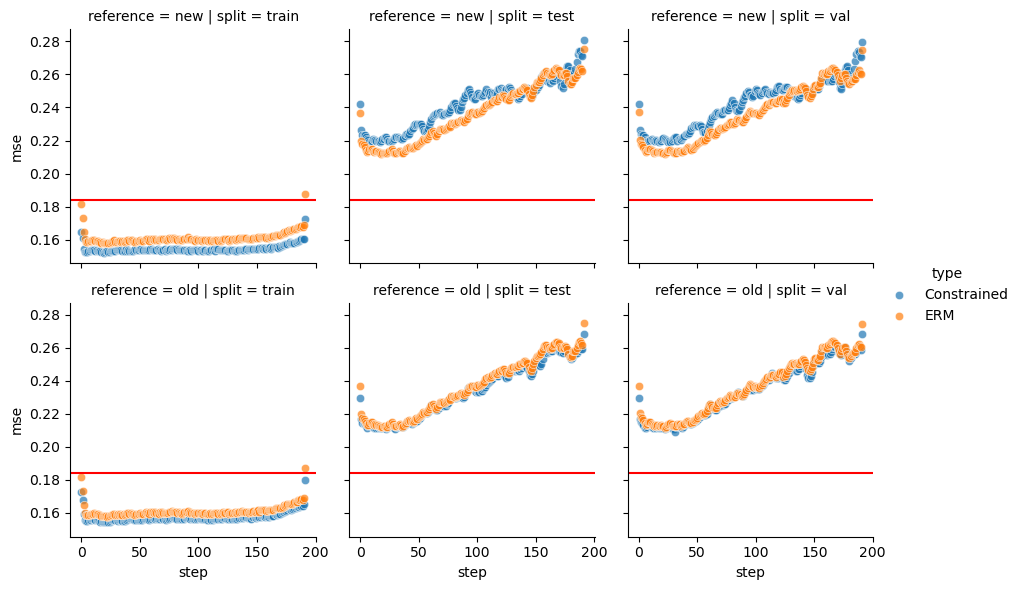

In [62]:

g = sns.FacetGrid(to_plot, col="split", hue="type",row='reference')
g.map(sns.scatterplot, "step", "mse", alpha=.7) 
g.add_legend()
# add the hline
data_summary=to_plot.groupby(['run_id','model','data_path','reference','split','constraint_level'])[['mse']].mean().reset_index()
# Pivot mse with columns based on split and reference
display(data_summary.pivot_table(index=['run_id','model','data_path','constraint_level'],columns=['split','reference'],values=['mse']).reset_index())
for axl in g.axes:
    for ax in axl:    
        ax.axhline(y=reformer_electricity_192.constraint_level.tolist()[0], color='r', linestyle='-')
plt.show()

- **Conclusion:** Let's try another dataset. Chose exchange because in Autoformer benchmarks, there was a huge improvement.